# Energy A.I. Hackathon 2023 Workflow - Data Derricks

#### Matthew Heichel (PGE), Nurul Hisham (PGE), Faraz Rahman (ECE), Saffat Reza (BAX), Viren Govin (MIS):

#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

The problem at hand is to determine the average pump difference for 15 wells based on previous well data containing various predictor features. To address this, we employed a machine learning workflow to develop a predictive model capable of estimating the average pump difference. Our findings revealed an average pump difference of 20.9 in our prediction model. Additionally, we quantified the uncertainty associated with our predictions, determining an uncertainty average of 13.2. In light of these findings, we recommend utilizing the Campbell fluid to minimize fluid loss and maximize hole cleaning for future operations.

___

### Workflow Goal

Create an optimal machine learning model to determine lowest pump difference for 15 wells 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$


# Iterative Imputation and Feature Selection

The provided Python code begins by importing essential libraries for data manipulation and machine learning. It loads a dataset from 'HackathonData2024.csv' into a Pandas DataFrame and then identifies columns containing string data for subsequent label encoding. The dataset is split into features and a target variable while also removing rows with missing values in the target variable column. An IterativeImputer is employed to fill missing values in the feature columns using a RandomForestRegressor estimator. The code performs feature selection using mutual_info_regression, calculates feature importance scores, and displays the top 5 selected features based on their scores.


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('HackathonData2024.csv')

# Identify columns with string data
string_columns = data.select_dtypes(include=['object']).columns

# Apply label encoding to each string column
label_encoder = LabelEncoder()
for column in string_columns:
   data[column] = label_encoder.fit_transform(data[column])

# Separate features and target variable
X = data.drop(['Well ID', 'Avg Pump Difference'], axis=1)
y = data['Avg Pump Difference']

# Drop rows with NaN values in the 'Avg Pump Difference' column
data = data.dropna(subset=['Avg Pump Difference'])

# # Impute missing values for all other columns
# imputer = SimpleImputer(strategy='median')  # Adjust strategy if needed
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#Iterative Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Assuming X is your dataframe with missing values

# Create the IterativeImputer model
# You can choose a different estimator than RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(), 
                           max_iter=100,  # number of imputation iterations
                           random_state=0)

X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)


# # Fit the imputer model on the dataset to impute the missing data

# imputer = SimpleImputer(strategy ='mean')
# X_imputed = imputer.fit_transform(X)
# X_imputed = pd.DataFrame(X_imputed, columns = X.columns)


# Concatenate 'Avg Pump Difference' back to the imputed data
X_imputed['Avg Pump Difference'] = y


# Use mutual_info_regression for feature selection
y_imputed = X_imputed['Avg Pump Difference'].dropna()
X_imputed_features = X_imputed.drop('Avg Pump Difference', axis=1).loc[y_imputed.index]

#MUTUAL INFO REGRESSION

feature_scores = pd.DataFrame({'Feature': X_imputed_features.columns, 'Score': mutual_info_regression(X_imputed_features, y_imputed)})
 
# Sort features by score in descending order
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Display selected features based on a threshold (e.g., top 10 features)
selected_features = feature_scores.head(5)['Feature']
print("Selected Features:", selected_features.tolist())


Selected Features: ['Pressure Gradient (psi/ft) new', 'Avg Open Pressure', 'Fluid System', 'Avg Close Pressure', 'TVD']


# Building XGBoost Model

The provided Python code involves building and training an XGBoost regression model for a given dataset. It begins by importing necessary libraries, including pandas for data manipulation, xgboost for the XGBoost model, and scikit-learn modules for data splitting and evaluation metrics. The data is split into training and testing sets, and an XGBoost Regressor model is initialized. A GridSearchCV is set up to perform hyperparameter tuning for the XGBoost model, considering different combinations of parameters like the number of estimators, learning rate, max depth, colsample bytree, and subsample. The model is fitted with the training data, and the best hyperparameters are obtained from the grid search. Finally, the XGBoost model is updated with the optimized parameters and trained on the training data.

In [2]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming X_imputed_features is your feature matrix and y_imputed is your target variable

# Choose your selected features
#selected_features = ['Pressure Gradient (psi/ft) new', 'Avg Open Pressure', 'Fluid System', 'Avg Close Pressure']

# Select the features from the DataFrame
X_selected = X_imputed_features[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_imputed, test_size=0.2, random_state=42)
# Define the XGBoost Regressor model
xgb_model = XGBRegressor(random_state=42)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8, 1],
    'subsample': [0.7, 0.8, 1]
}

# Create GridSearchCV object for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Fit the model with grid search
xgb_grid_search.fit(X_selected, y_imputed)

# Get the best parameters
best_xgb_params = xgb_grid_search.best_params_

# Update the XGBoost model with the best parameters
xgb_model_optimized = XGBRegressor(random_state=42, **best_xgb_params)

# Train the optimized XGBoost model
trainedmodel=xgb_model_optimized.fit(X_train, y_train)






# Prediction Variance Calculation

The provided Python code defines two functions and performs calculations related to prediction variances for an XGBoost model:

calculate_prediction_variance(model, X_train, y_train, X_test): This function calculates the variance of predictions for an XGBoost model. It takes the trained model (model), training data (X_train and y_train), and the test data (X_test) as input. It first predicts the target values for the training data and calculates the residuals. Then, it estimates the residual variance and assigns it to all test samples as y_pred_variance.

calculate_variance_between_predictions(predictions1, predictions2): This function calculates the variance between two sets of predictions. It takes two sets of predictions (predictions1 and predictions2) and calculates the variance of their difference.

After defining these functions, the code proceeds to use the trained XGBoost model (trainedmodel) to calculate the prediction variance and mean predictions for the test data. It then generates multiple realizations of predictions based on a normal distribution with the calculated mean and variance for each test sample. These realizations are stored in the realizations array. Finally, the code calculates the variance between these realizations and the actual test target values, as well as the variance between the mean predictions and the model's predictions for the test data.

In [3]:
import numpy as np

def calculate_prediction_variance(model, X_train, y_train, X_test):
    """
    Calculate the variance of predictions for an XGBoost model.
    """
    y_train_pred = model.predict(X_train)
    residuals = y_train - y_train_pred
    estimated_residual_variance = np.var(residuals)
    y_pred_variance = np.full(len(X_test), estimated_residual_variance)
    return y_pred_variance

def calculate_variance_between_predictions(predictions1, predictions2):
    """
    Calculate the variance between two sets of predictions.
    """
    return np.var(predictions1 - predictions2)

# Assuming 'trainedmodel', 'X_train', 'y_train', 'X_test', and 'y_test' are already defined
y_pred_variance = calculate_prediction_variance(trainedmodel, X_train, y_train, X_test)
y_pred_mean = trainedmodel.predict(X_test)

num_realizations = 100
realizations = np.zeros((len(y_test), num_realizations))

for i in range(len(y_test)):
    mean_prediction = y_pred_mean[i]
    variance = y_pred_variance[i]
    
    if variance < 0:
        raise ValueError("Variance cannot be negative")

    realizations[i, :] = np.random.normal(loc=mean_prediction, scale=np.sqrt(variance), size=num_realizations)

final_predicted_values = np.mean(realizations, axis=1)
variance_between_predictions_and_actual = np.var(final_predicted_values - y_test)
variance_between_mean_and_model = calculate_variance_between_predictions(y_pred_mean, trainedmodel.predict(X_test))


# Monte Carlo Simulation Statistics

The provided code calculates and prints summary statistics for the Monte Carlo predictions and creates a scatter plot for visualization. Here's a breakdown of what it does:

mean_mae_monte_carlo: Calculates the mean absolute error (MAE) between the actual target values (y_test) and the final predicted values obtained from the Monte Carlo simulations.

mean_mse_monte_carlo: Calculates the mean squared error (MSE) between the actual target values (y_test) and the final predicted values obtained from the Monte Carlo simulations.

mean_r2_monte_carlo: Calculates the R-squared score between the actual target values (y_test) and the final predicted values obtained from the Monte Carlo simulations.

The code then prints these summary statistics, including the mean MAE, mean MSE, and mean R-squared for the Monte Carlo predictions.

Visualization: It creates a scatter plot where the x-axis represents the actual target values (y_test), and the y-axis represents the mean Monte Carlo predicted values (final_predicted_values). It also includes a red dashed line representing a perfect fit, indicating where predicted values would match the actual values.

The scatter plot is a visual representation of how well the Monte Carlo predictions align with the actual values, providing insights into the model's performance.

Mean Monte Carlo MAE: 12.389567108199326
Mean Monte Carlo MSE: 300.37392504406256
Mean Monte Carlo R-squared: 0.38439464941606016


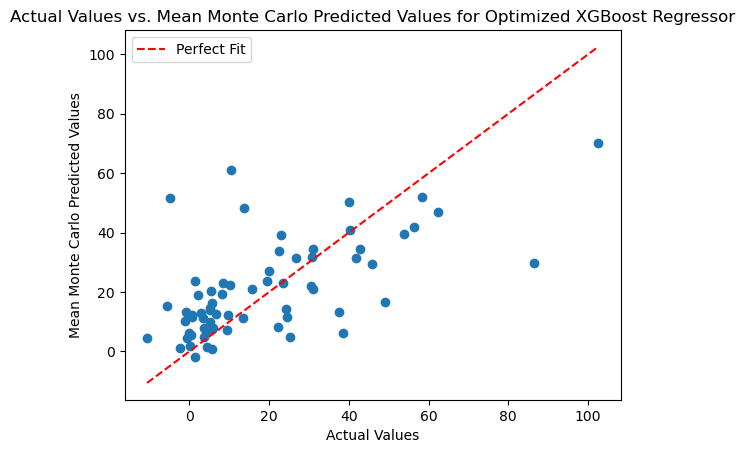

In [4]:
# Calculate summary statistics for the mean Monte Carlo predictions
mean_mae_monte_carlo = np.mean(np.abs(y_test - final_predicted_values))
mean_mse_monte_carlo = np.mean((y_test - final_predicted_values)**2)
mean_r2_monte_carlo = r2_score(y_test, final_predicted_values)

print(f"Mean Monte Carlo MAE: {mean_mae_monte_carlo}")
print(f"Mean Monte Carlo MSE: {mean_mse_monte_carlo}")
print(f"Mean Monte Carlo R-squared: {mean_r2_monte_carlo}")

# Visualization: Scatter plot of mean Monte Carlo predictions vs actual values
plt.scatter(y_test, final_predicted_values)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Mean Monte Carlo Predicted Values")
plt.title("Actual Values vs. Mean Monte Carlo Predicted Values for Optimized XGBoost Regressor")
plt.legend()
plt.show()



#

This code snippet uses the scipy.stats library and matplotlib to perform statistical analysis and create a visual representation of the cumulative distribution of Monte Carlo percentile values. Here's an explanation of what each part of the code does:

flat_realizations = realizations.flatten(): Flattens the 2D array of Monte Carlo realizations into a 1D array.

percentiles = np.array([stats.percentileofscore(flat_realizations, x, 'rank') for x in flat_realizations]): Calculates the percentiles for each value in flat_realizations and stores them in the percentiles array.

bins = np.linspace(0, 100, num=11): Defines percentile bins from 0 to 100, divided into 10 intervals.

hist, bin_edges = np.histogram(percentiles, bins=bins, density=True): Computes the histogram of percentiles using the defined bins, with density=True for normalized proportions.

proportions = hist * np.diff(bin_edges): Calculates the proportions for each bin by multiplying the histogram values with the bin width.

cumulative_proportions = np.cumsum(proportions): Computes the cumulative sum of proportions for creating the cumulative distribution plot.

ks_statistic, p_value = stats.ks_2samp(percentiles, np.random.uniform(0, 100, size=len(percentiles))): Performs a two-sample Kolmogorov-Smirnov (KS) test to compare the distribution of percentiles against a uniform distribution from 0 to 100. The ks_statistic represents the KS statistic, and the p_value is the associated p-value.

The code then creates a scatter plot of cumulative proportions against percentile intervals, along with a red dashed line representing a perfect fit (a 45-degree line).

plt.xlabel, plt.ylabel, and plt.title set labels and the title for the plot.

plt.legend() adds a legend to the plot.

plt.text(0.1, 0.8, ...) displays the KS statistic and p-value on the plot.

Finally, plt.show() displays the plot.

The resulting plot and statistical tests help visualize how well the Monte Carlo percentile values align with a uniform distribution and assess the goodness-of-fit.

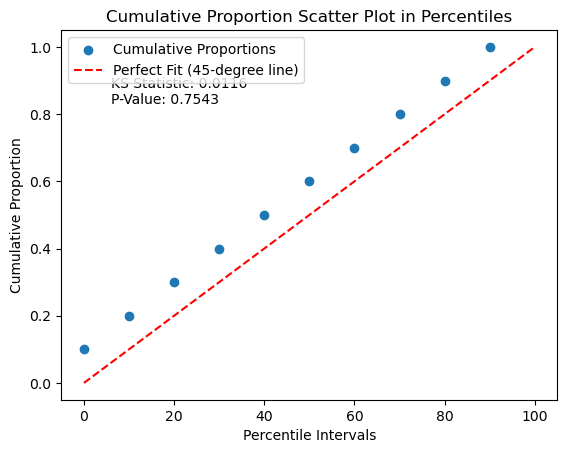

In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

# Flatten the realizations to a single array
flat_realizations = realizations.flatten()

# Convert realizations into percentiles
percentiles = np.array([stats.percentileofscore(flat_realizations, x, 'rank') for x in flat_realizations])

# Create percentile bins from 0 to 100
bins = np.linspace(0, 100, num=11)

# Calculate histogram of percentiles
hist, bin_edges = np.histogram(percentiles, bins=bins, density=True)

# Calculate proportions
proportions = hist * np.diff(bin_edges)

# Calculate cumulative sum of proportions for scatter plot
cumulative_proportions = np.cumsum(proportions)

# Perform Kolmogorov-Smirnov test against a uniform distribution from 0 to 100
ks_statistic, p_value = stats.ks_2samp(percentiles, np.random.uniform(0, 100, size=len(percentiles)))

# Plot the scatter plot with a line showing a 45-degree angle
plt.scatter(bins[:-1], cumulative_proportions, label="Cumulative Proportions")
plt.plot([0, 100], [0, 1], 'r--', label="Perfect Fit (45-degree line)")
plt.xlabel("Percentile Intervals")
plt.ylabel("Cumulative Proportion")
plt.title("Cumulative Proportion Scatter Plot in Percentiles")
plt.legend()

# Display KS statistic and p-value
plt.text(0.1, 0.8, f'KS Statistic: {ks_statistic:.4f}\nP-Value: {p_value:.4f}', transform=plt.gca().transAxes)

plt.show()


The code reads data with missing 'Avg Pump Difference' values, encodes string columns, imputes missing values, makes predictions, generates realizations, and stores them in 'nan_predictions_df'.

In [7]:
# Identify rows where 'Avg Pump Difference' is NaN before dropping NaNs in 'Avg Pump Difference'

data2 = pd.read_csv('HackathonData2024.csv')

nan_rows = data2[data2['Avg Pump Difference'].isna()]



# Drop 'Well ID' and 'Avg Pump Difference' columns
X_nan = nan_rows.drop(['Well ID', 'Avg Pump Difference'], axis=1)

# Apply label encoding to string columns, fitting a new encoder for each column
for column in string_columns:
    if X_nan[column].dtype == object:
        # Fit a new label encoder for each column in X_nan
        new_label_encoder = LabelEncoder()
        X_nan[column] = new_label_encoder.fit_transform(X_nan[column].astype(str))

# Continue with the rest of your code for imputation and prediction

# Impute missing values in these rows
X_nan_imputed = pd.DataFrame(imputer.transform(X_nan), columns=X_nan.columns)

# Select the same features as used in the model
X_nan_selected = X_nan_imputed[selected_features]

# Predict using the trained model
nan_predictions = trainedmodel.predict(X_nan_selected)

# Generate the distribution using the average variance from the training set
average_variance = np.mean(y_pred_variance)
num_realizations = 100
nan_realizations = np.zeros((len(nan_predictions), num_realizations))

for i in range(len(nan_predictions)):
    mean_prediction = nan_predictions[i]
    variance = average_variance

    if variance < 0:
        raise ValueError("Variance cannot be negative")

    nan_realizations[i, :] = np.random.normal(loc=mean_prediction, scale=np.sqrt(variance), size=num_realizations)

# Create a DataFrame to store these predictions and realizations
nan_predictions_df = pd.DataFrame(nan_realizations, columns=[f'Realization_{i}' for i in range(1, num_realizations + 1)])
nan_predictions_df['Predicted_Mean'] = nan_predictions


This code adds the 'Well ID' to the 'nan_predictions_df', reorders the columns to have 'Well ID' as the first column, and then outputs the list of realizations for each well.

In [8]:
import pandas as pd
import numpy as np

# Add 'Well_ID' from 'nan_rows' to 'nan_predictions_df'
nan_predictions_df['Well_ID'] = nan_rows['Well ID'].values

# Convert 'Well_ID' to string to match the format 'Well_ID'
nan_predictions_df.rename(columns={'Well ID': 'Well_ID'}, inplace=True)

# Assuming you've already generated 'nan_predictions' and 'nan_realizations' as per the previous code block
# Now, let's construct the column names for the CSV
column_names = ['Well_ID', 'Est Pump Difference, GPM'] + [f'R{i}, GPM' for i in range(1, 101)]

# Create a new DataFrame with these column names
new_df = pd.DataFrame(columns=column_names)

# Fill in the 'Well_ID' and 'Est Pump Difference, GPM' columns from 'nan_predictions_df'
new_df['Well_ID'] = nan_predictions_df['Well_ID']
new_df['Est Pump Difference, GPM'] = nan_predictions_df['Predicted_Mean']

# Fill in each realization
for i in range(1, 101):
    new_df[f'R{i}, GPM'] = nan_predictions_df[f'Realization_{i}']

# Now 'new_df' is the DataFrame you'll want to save as a CSV, following the specified structure
# Save the new DataFrame to CSV
new_csv_path = 'new_solution.csv'  # Use the /mnt/data directory to save the file in the AI's filesystem
new_df.to_csv(new_csv_path, index=False)

print(f"New CSV file saved to: {new_csv_path}")


New CSV file saved to: new_solution.csv


In [ ]:

realizations

array([[ 2.62484768e+01,  1.29600372e+01,  3.17297601e+01, ...,
         9.83076461e+00,  1.15403985e+01, -1.81322103e-03],
       [ 3.13339662e+01,  2.43749712e+01,  1.32656861e+01, ...,
         2.48388590e+01,  2.93902020e+01,  3.46768245e+01],
       [ 2.07901761e+01,  4.56273529e+00,  2.47160758e+00, ...,
         1.55001972e+01,  3.78708187e+01,  2.64461275e+01],
       ...,
       [-1.35612712e+01, -1.53425016e+01, -3.67446520e-01, ...,
         5.57448414e+00,  3.43518443e+00,  2.62209151e+00],
       [-6.27544217e+00, -2.41839753e+00,  1.26986203e+01, ...,
         2.37903572e+01,  2.13370537e+01,  3.37548919e+01],
       [ 6.86083033e+00,  1.92315546e+01,  1.82414926e+01, ...,
         3.16315964e+01, -1.56797600e+01,  4.68060897e+00]])